## Sales Forecasting using Auto Regression

Importing Packages:

In [39]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error

In [40]:
def load_data():
    path = r"C:\Users\suman\Desktop\brazilian-ecommerce"
    files = glob.glob(path + "/*.csv")
    files_list  = []
    for filenames in files:
        df = pd.read_csv(filenames)
        files_list.append(df)
    return files_list   

In [41]:
files_list=load_data()
customers_df = files_list[0]
geolocation_df = files_list[1]
orders_df = files_list[2]
order_item_df = files_list[3]
order_payment_df = files_list[4]
order_review_df = files_list[5]
products_df = files_list[6]
sellers_df = files_list[7]
prod_category_df = files_list[8]
del files_list

In [42]:
# merge dataframes :

df = pd.merge(customers_df,orders_df,how="inner",on="customer_id")
df1 = pd.merge(df,orders_df,how="inner",on="order_id")
df2 = pd.merge(df,order_item_df,how="inner",on="order_id" )

In [43]:
df2.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


In [44]:
filtered = df2.columns.isin(["customer_unique_id",
                       "customer_zip_code_prefix",
                       "order_id","order_delivered_carrier_date",
                       "order_delivered_customer_date",
                       "order_approved_at","order_estimated_delivery_date",
                       "product_id","seller_id",
                       "shipping_limit_date"])
df_filtered = df2.iloc[:,~filtered]
df_filtered.head()

,customer_id,customer_city,customer_state,order_status,order_purchase_timestamp,order_item_id,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,franca,SP,delivered,2017-05-16 15:05:35,1,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,sao bernardo do campo,SP,delivered,2018-01-12 20:48:24,1,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,sao paulo,SP,delivered,2018-05-19 16:07:45,1,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,mogi das cruzes,SP,delivered,2018-03-13 16:06:38,1,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,campinas,SP,delivered,2018-07-29 09:51:30,1,230.00,22.25


In [45]:
print(df_filtered.isna().sum())

customer_id                 0
customer_city               0
customer_state              0
order_status                0
order_purchase_timestamp    0
order_item_id               0
price                       0
freight_value               0
dtype: int64


In [46]:
df_sales = df_filtered.filter(["order_purchase_timestamp","price"])
df_sales = df_sales.sort_values(by="order_purchase_timestamp")
df_sales.order_purchase_timestamp = pd.to_datetime(df_sales.order_purchase_timestamp)
df_sales = df_sales.set_index("order_purchase_timestamp")

Text(0, 0.5, 'Avg_sale')

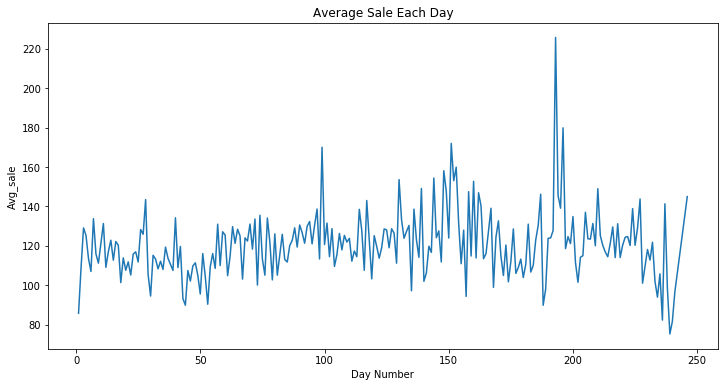

In [47]:
# timeseries plot
df_sales = df_sales.iloc[(df_sales.index > "2018-01-01")]
res = df_sales.groupby(df_sales.index.dayofyear).mean()
plt.figure(figsize=(12,6))
plt.plot(res)
plt.title("Average Sale Each Day")
plt.xlabel("Day Number")
plt.ylabel("Avg_sale")

### Checking the stationarity

1.Plotting rolling statistics \
2.Dickey-Fuller test

Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.


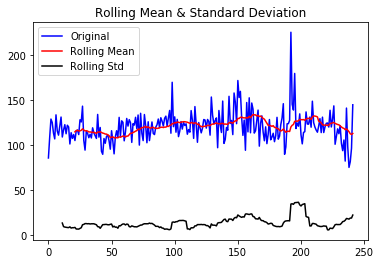

ADF Stastistic: -5.704077
p-value: 0.000001
The graph is stationery
Critical values:
	1%: -3.458
	5%: -2.874
	10%: -2.573


In [48]:
def test_stationarity(x):


    #Determing rolling statistics
    rolmean = x.rolling(window=22,center=False).mean()

    rolstd = x.rolling(window=12,center=False).std()
    
    #Plot rolling statistics:
    orig = plt.plot(x.values, color='blue',label='Original')
    mean = plt.plot(rolmean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolstd.values, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey Fuller test    
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    pvalue=result[1]
    for key,value in result[4].items():
         if result[0]>value:
            print("The graph is non stationery")
            break
         else:
            print("The graph is stationery")
            break;
    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
test_stationarity(res)

          price     price
price  1.000000  0.193328
price  0.193328  1.000000


<Figure size 864x576 with 0 Axes>

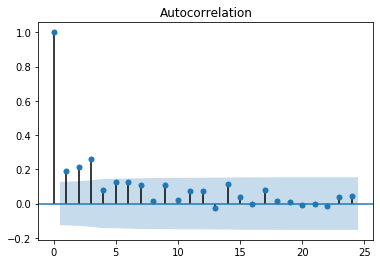

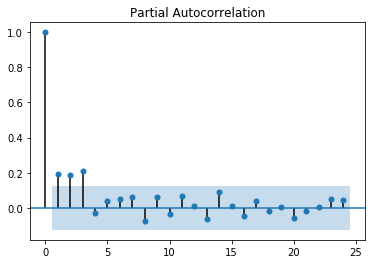

In [49]:
plt.figure(figsize=(12,8))
plot_acf(res)
plot_pacf(res)
test = pd.concat([res.shift(1),res],axis=1)
print(test.corr())

,t-1,t+1
t-1,1.000000,0.193328
t+1,0.193328,1.000000


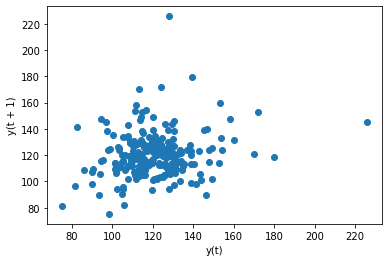

In [50]:
#Clearly show some correlation
lag_plot(res)
res_corr = pd.concat([res.shift(1),res],axis=1)
res_corr.columns=['t-1','t+1']
res_corr.corr(method="pearson")

## Auto-Regression Model

An autoregression model is a linear regression model that uses lagged variables as input variables.

We could calculate the linear regression model manually using the LinearRegession class in scikit-learn and manually specify the lag input variables to use.

Alternately, the statsmodels library provides an autoregression model where you must specify an appropriate lag value and trains a linear regression model. It is provided in the AutoReg class.

We can use this model by first creating the model AR() and then calling fit() to train it on our dataset. This returns an model_fit() object.

Once fit, we can use the model to make a prediction by calling the predict() function for a number of observations in the future. This creates 40-day forecast.

In [51]:
# split dataset
X = list(res.price)
train, test = X[1:len(X)-40], X[len(X)-40:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print(model_fit.summary())
print('The lag value chose is: %s' % model_fit.k_ar)
print('Coefficients:\n %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

                               AR Model Results                               
Dep. Variable:                      y   No. Observations:                  201
Model:                         AR(14)   Log Likelihood                -777.714
Method:                          cmle   S.D. of innovations             15.486
Date:                Tue, 05 May 2020   AIC                              5.651
Time:                        16:27:03   BIC                              5.927
Sample:                             0   HQIC                             5.763
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.7904     19.987      2.491      0.013      10.616      88.965
L1.y           0.1168      0.077      1.519      0.129      -0.034       0.268
L2.y           0.2047      0.077      2.657      0.0

Test RMSE: 17.345


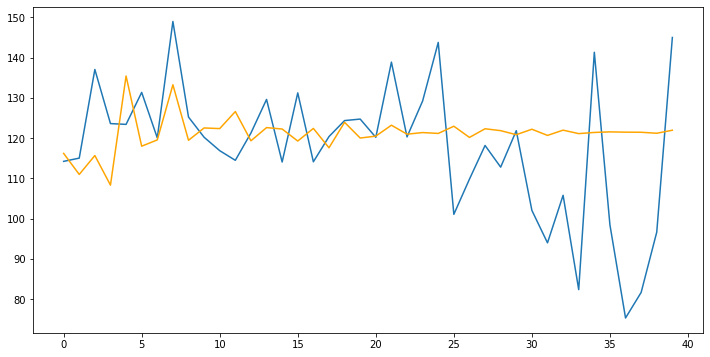

In [52]:
# Plotting predictions vs testing
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.figure(figsize=(12,6))
plt.plot(test)
plt.plot(predictions, color='orange')
plt.show()

In [53]:
# Get predictions
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))

predicted=116.191834, expected=114.211605
predicted=110.962912, expected=115.017925
predicted=115.659663, expected=137.048713
predicted=108.310328, expected=123.600917
predicted=135.421210, expected=123.401119
predicted=117.983976, expected=131.350694
predicted=119.542139, expected=120.048190
predicted=133.246067, expected=148.976682
predicted=119.451989, expected=125.226474
predicted=122.513883, expected=120.202334
predicted=122.356024, expected=116.869741
predicted=126.587770, expected=114.471012
predicted=119.324247, expected=121.254121
predicted=122.600410, expected=129.605693
predicted=122.249371, expected=114.050513
predicted=119.264929, expected=131.226488
predicted=122.398647, expected=114.104362
predicted=117.587900, expected=120.369639
predicted=123.913251, expected=124.348696
predicted=120.009839, expected=124.719142
predicted=120.484649, expected=120.189491
predicted=123.199081, expected=138.873172
predicted=120.965656, expected=120.290125
predicted=121.368214, expected=129

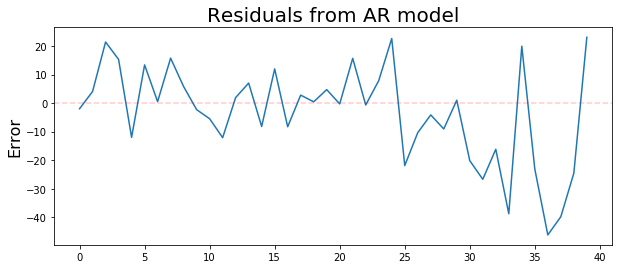

In [54]:
# calculate residuals
residuals = [test[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)
# plot residuals
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("Residuals from AR model", fontsize=20)
plt.ylabel("Error",fontsize=16)
plt.axhline(0,color='r',linestyle='--',alpha=0.2)
plt.show()

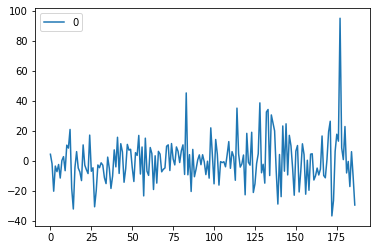

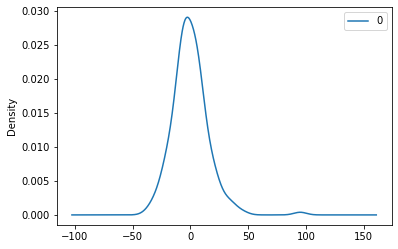

In [55]:
#Residual and density plot of the model
rrr=pd.DataFrame(model_fit.resid)
rrr.plot()
rrr.plot(kind='kde')

In [56]:
test_df=pd.DataFrame(test)
print('Mean absolute percent error:', round(np.mean(abs(residuals/test_df)),5))

Mean absolute percent error: 0    0.12497
dtype: float64


### 30-Days sales Predicted by the model

In [57]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
model_final = AR(res)
Results_AR = model_final.fit()
print('The lag value chose is: %s' % Results_AR.k_ar)
sales_predicted = Results_AR.predict(start=len(res),end=len(res)+30 , dynamic=False)
sales_predicted = pd.DataFrame(sales_predicted, columns = ['Average sale($)'])
sales_predicted.head()

The lag value chose is: 15


C:\Users\suman\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\suman\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


,Average sale($)
242,113.215175
243,123.837548
244,113.571120
245,114.736429
246,118.920754


### Plotting Time series plot with Forecasted values 

Text(0, 0.5, 'Avg sale in Dollar')

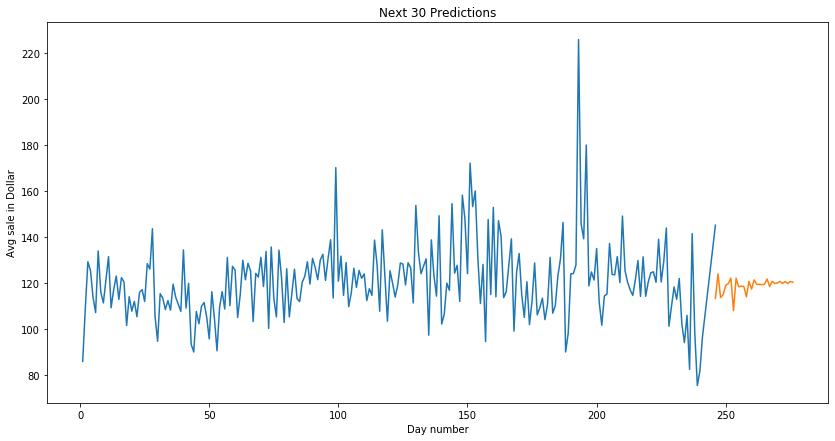

In [58]:
plt.figure(figsize=(14,7))
sales_predicted.index = list(range(max(res.index),max(res.index)+31))
plt.plot(res)
plt.plot(sales_predicted)
plt.title("Next 30 Predictions")
plt.xlabel("Day number")
plt.ylabel("Avg sale in Dollar")